# Reading a Neon dataset/recording
In this tutorial, we will show how to load a single Neon recording downloaded from [Pupil Cloud](https://docs.pupil-labs.com/neon/pupil-cloud/) and give an overview of the data structure.

## Reading sample data
We will use a sample recording produced by the NCC Lab, called `boardView`. This project (collection of recordings on Pupil Cloud) contains two recordings downloaded with the `Timeseries Data + Scene Video` option and a marker mapper enrichment. It can be downloaded with the `get_sample_data()` function. The function returns a `Pathlib.Path` [(reference)](https://docs.python.org/3/library/pathlib.html#pathlib.Path) instance pointing to the downloaded and unzipped directory. PyNeon accepts both `Path` and `string` objects but internally always uses `Path`.

In [1]:
from pyneon import get_sample_data, NeonDataset, NeonRecording

# Download sample data (if not existing) and return the path
sample_dir = get_sample_data("boardView")
print(sample_dir)

/home/runner/work/PyNeon/PyNeon/data/boardView


The `OfficeWalk` data has the following structure:

```text
boardView
├── Timeseries Data + Scene Video
│   ├── boardview1-d4fd9a27
│   │   ├── info.json
│   │   ├── gaze.csv
│   │   └── ....
│   ├── boardview2-713532d5
│   │   ├── info.json
│   │   ├── gaze.csv
│   │   └── ....
|   ├── enrichment_info.txt
|   └── sections.csv
└── boardView_MARKER-MAPPER_boardMapping_csv
```

The `Timeseries Data + Scene Video` folder contains what PyNeon refers to as a `NeonDataset`. It consists of two recordings, each with its own `info.json` file and data files. These recordings can be loaded either individually as a `NeonRecording`, or as a collective `NeonDataset`.

To load a `NeonDataset`, specify the path to the `Timeseries Data + Scene Video` folder:

In [2]:
dataset_dir = sample_dir / "Timeseries Data + Scene Video"
dataset = NeonDataset(dataset_dir)
print(dataset)

NeonDataset | 2 recordings


`NeonDataset` provides an index-based access to its recordings. The recordings are stored in the `recordings` attribute, which contains a list of `NeonRecording` instances. You can access individual recordings by index:

In [3]:
recording = dataset[0]  # Internally accesses the recordings attribute
print(type(recording))
print(recording.recording_dir)

<class 'pyneon.recording.NeonRecording'>
/home/runner/work/PyNeon/PyNeon/data/boardView/Timeseries Data + Scene Video/boardview2-713532d5


Alternatively, you can directly load a single `NeonRecording` by specifying the recording's folder path:

In [4]:
recording_dir = dataset_dir / "boardview1-d4fd9a27"
recording = NeonRecording(recording_dir)
print(type(recording))
print(recording.recording_dir)

<class 'pyneon.recording.NeonRecording'>
/home/runner/work/PyNeon/PyNeon/data/boardView/Timeseries Data + Scene Video/boardview1-d4fd9a27


## Data and metadata of a NeonRecording
You can quickly get an overview of the metadata and contents of a `NeonRecording` by printing the instance. The basic metadata (e.g., recording and wearer ID, recording start time and duration) and the path to available data will be displayed. At this point, the data is simply located from the recording's folder path, but it is not yet loaded into memory.

In [5]:
print(recording)


Recording ID: d4fd9a27-3e28-45bf-937f-b9c14c3c1c5e
Wearer ID: af6cd360-443a-4d3d-adda-7dc8510473c2
Wearer name: Qian
Recording start time: 2024-11-26 11:44:48.937000
Recording duration: 32.046s
                 exist                 filename                                                                                                                      path
3d_eye_states     True        3d_eye_states.csv        /home/runner/work/PyNeon/PyNeon/data/boardView/Timeseries Data + Scene Video/boardview1-d4fd9a27/3d_eye_states.csv
blinks            True               blinks.csv               /home/runner/work/PyNeon/PyNeon/data/boardView/Timeseries Data + Scene Video/boardview1-d4fd9a27/blinks.csv
events            True               events.csv               /home/runner/work/PyNeon/PyNeon/data/boardView/Timeseries Data + Scene Video/boardview1-d4fd9a27/events.csv
fixations         True            fixations.csv            /home/runner/work/PyNeon/PyNeon/data/boardView/Timeseries Data + S

As seen in the output, this recording includes all data files. This tutorial will focus on non-video data. For processing video, refer to the [Neon video tutorial](video.ipynb).

Individual data streams can be accessed as properties of the `NeonRecording` instance. For example, the gaze data can be accessed as `recording.gaze`, and upon accessing, the tabular data is loaded into memory. On the other hand, if you try to access unavailable data, PyNeon will return `None` and a warning message.

In [6]:
# Gaze and fixation data are available
gaze = recording.gaze
print(f"recording.gaze is {gaze}")

saccades = recording.saccades
print(f"recording.saccades is {saccades}")

video = recording.video
print(f"recording.video is {video}")

recording.gaze is <pyneon.stream.NeonGaze object at 0x7fbdd29e86b0>
recording.saccades is <pyneon.events.NeonSaccades object at 0x7fbdd4e93710>
recording.video is < cv2.VideoCapture 0x7fbdd2f14b10>


PyNeon reads tabular CSV file into specialized classes (e.g., gaze.csv to `NeonGaze`) which all have a `data` attribute that holds the tabular data as a `pandas.DataFrame` [(reference)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). Depending on the nature of the data, such classes could be of `NeonStream` or `NeonEV` super classes. `NeonStream` contains (semi)-continuous data streams, while `NeonEV` (dubbed so to avoid confusion with the `NeonEvent` subclass that holds data from `events.csv`) contains sparse event data.

The class inheritance relationship is as follows:

```text
NeonTabular
├── NeonStream
│   ├── NeonGaze
│   ├── NeonEyeStates
│   └── NeonIMU
└── NeonEV
    ├── NeonBlinks
    ├── NeonSaccades
    ├── NeonFixations
    └── NeonEvents
```

## Data as DataFrames

The essence of `NeonTabular` is the `data` attribute—a `pandas.DataFrame`. This is a common data structure in Python for handling tabular data. For example, you can print the first 5 rows of the gaze data by calling `gaze.data.head()`, and inspect the data type of each column by calling `gaze.data.dtypes`. 

Theoretically, you could re-assign `gaze.data` to `gaze_df`, however the conversion scripts written in the next section only work at the class level and not on the dataframe level.

In [7]:
print(gaze.data.head())
print(gaze.data.dtypes)

                     gaze x [px]  gaze y [px]  worn  fixation id  blink id  \
timestamp [ns]                                                               
1732621490425631343      697.829      554.242     1            1      <NA>   
1732621490430625343      698.096      556.335     1            1      <NA>   
1732621490435625343      697.810      556.360     1            1      <NA>   
1732621490440625343      695.752      557.903     1            1      <NA>   
1732621490445625343      696.108      558.438     1            1      <NA>   

                     azimuth [deg]  elevation [deg]  
timestamp [ns]                                       
1732621490425631343      -7.581023         3.519804  
1732621490430625343      -7.563214         3.385485  
1732621490435625343      -7.581576         3.383787  
1732621490440625343      -7.713686         3.284294  
1732621490445625343      -7.690596         3.250055  
gaze x [px]        float64
gaze y [px]        float64
worn                 

In [8]:
print(saccades.data.head())
print(saccades.data.dtypes)

                      saccade id   end timestamp [ns]  duration [ms]  \
start timestamp [ns]                                                   
1732621490876132343            1  1732621490891115343             15   
1732621491241357343            2  1732621491291481343             50   
1732621491441602343            3  1732621491516601343             75   
1732621491626723343            4  1732621491696847343             70   
1732621491917092343            5  1732621491977090343             60   

                      amplitude [px]  amplitude [deg]  mean velocity [px/s]  \
start timestamp [ns]                                                          
1732621490876132343        14.938179         0.962102           1025.709879   
1732621491241357343       130.743352         8.378644           2700.713283   
1732621491441602343       241.003342        15.391730           3615.380044   
1732621491626723343       212.619205        13.608618           3757.394092   
1732621491917092343  

PyNeon performs the following preprocessing when reading the CSV files:
1. Removes the redundant `section id` and `recording id` columns that are present in the raw CSVs.
2. Sets the `timestamp [ns]` (or `start timestamp [ns]` for most event files) column as the DataFrame index.
3. Automatically assigns appropriate data types to columns. For instance, `Int64` type is assigned to timestamps, `Int32` to event IDs (blink/fixation/saccade ID), and `float64` to float data (e.g. gaze location, pupil size).

Just like any other `pandas.DataFrame`, you can access individual rows, columns, or subsets of the data using the standard indexing and slicing methods. For example, `gaze.data.iloc[0]` returns the first row of the gaze data, and `gaze.data['gaze x [px]']` (or `gaze['gaze x [px]']`) returns the gaze x-coordinate column.

In [9]:
print(f"First row of gaze data:\n{gaze.data.iloc[0]}\n")
print(f"All gaze x values:\n{gaze['gaze x [px]']}")

First row of gaze data:
gaze x [px]         697.829
gaze y [px]         554.242
worn                    1.0
fixation id             1.0
blink id               <NA>
azimuth [deg]     -7.581023
elevation [deg]    3.519804
Name: 1732621490425631343, dtype: Float64

All gaze x values:
timestamp [ns]
1732621490425631343    697.829
1732621490430625343    698.096
1732621490435625343    697.810
1732621490440625343    695.752
1732621490445625343    696.108
                        ...   
1732621520958946343    837.027
1732621520964071343    836.595
1732621520969071343    836.974
1732621520974075343    835.169
1732621520979070343    833.797
Name: gaze x [px], Length: 6091, dtype: float64


## Useful attributes and methods for NeonStream and NeonEV
On top of analyzing `data` with `pandas.DataFrame` attributes and methods, you may also use attributes and methods of the `NeonStream` and `NeonEV` instances containing the `data` to facilitate Neon-specific data analysis. For example, `NeonStream` class has a `ts` property that allows quick access of all timestamps in the data as a `numpy.ndarray` [(reference)](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html).

Useful as they are, UTC timestamps in nanoseconds are usually too large for human comprehension. Often we would want to simply know what is the relative time for each data point since the stream start (which is different from the recording start). In PyNeon, this is referred to as `times` and is in seconds. You can access it as a `numpy.ndarray` by calling the `times` property.


In [10]:
print(gaze.ts)
print(gaze.times)

[1732621490425631343 1732621490430625343 1732621490435625343 ...
 1732621520969071343 1732621520974075343 1732621520979070343]
[0.0000000e+00 4.9940000e-03 9.9940000e-03 ... 3.0543440e+01 3.0548444e+01
 3.0553439e+01]


Timestamps (UTC, in ns), relative time (relative to the stream start, in s), and index are the three units of time that are most commonly used in PyNeon. For example, you can crop the stream by either timestamp or relative time by calling the `crop()` method. The method takes `start` and `end` of the crop window in either UTC timestamps or relative time, and uses `by` to specify which time unit is used. The method returns a new `NeonStream` instance with the cropped data.

In [11]:
print(f"Gaze data points before cropping: {len(gaze)}")

# Crop the gaze data to 5-10 seconds
gaze_crop = gaze.crop(5, 10, by="time")  # Crop by time
print(f"Gaze data points after cropping: {len(gaze_crop)}")

Gaze data points before cropping: 6091
Gaze data points after cropping: 999


You may also want to restrict one stream to the temporal range of another stream. This can be done by calling the `restrict()` method. The method takes another `NeonStream` instance as an argument and crops the stream to the intersection of the two streams' temporal ranges.

In [12]:
imu_crop = recording.imu.restrict(gaze_crop)
saccades_crop = saccades.restrict(gaze_crop)
print(
    f"IMU first timestamp: {imu_crop.first_ts} > Gaze first timestamp: {gaze_crop.first_ts}"
)
print(
    f"IMU last timestamp: {imu_crop.last_ts} < Gaze last timestamp: {gaze_crop.last_ts}"
)

IMU first timestamp: 1732621495435389343 > Gaze first timestamp: 1732621495430263343
IMU last timestamp: 1732621500421101343 < Gaze last timestamp: 1732621500424901343


There are many other attributes and methods available for `NeonStream` and `NeonEV` classes. For a full list, refer to the [API reference](https://ncc-brain.github.io/PyNeon/reference/stream.html). We will also cover some of them in the following tutorials (e.g., [interpolation and concatenation of streams](interpolate_and_concat.ipynb)).

## An example plot of cropped data

Below we show how to easily plot the gaze and saccade data we cropped just now. Since PyNeon data are stored in `pandas.DataFrame`, you can use any plotting library that supports `pandas.DataFrame` as input. Here we use `seaborn` and `matplotlib` to plot the gaze x, y coordinates and the saccade durations (shaded areas).

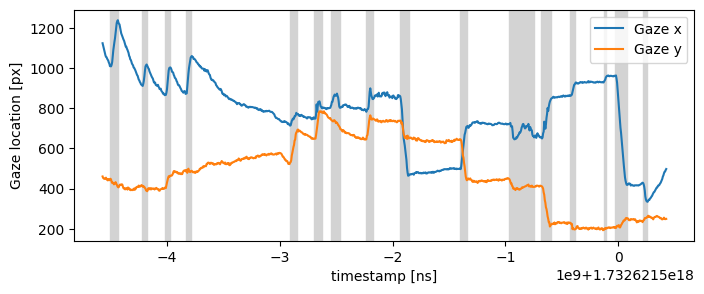

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure
fig, ax = plt.subplots(figsize=(8, 3))

# Visualize the 1st saccade
for _, sac in saccades_crop.data.iterrows():
    ax.axvspan(sac.name, sac["end timestamp [ns]"], color="lightgray")

# Visualize gaze x and y
sns.lineplot(
    ax=ax,
    data=gaze_crop.data,
    x=gaze_crop.data.index,
    y="gaze x [px]",
    label="Gaze x",
)
sns.lineplot(
    ax=ax,
    data=gaze_crop.data,
    x=gaze_crop.data.index,
    y="gaze y [px]",
    label="Gaze y",
)
ax.set_ylabel("Gaze location [px]")
plt.legend()
plt.show()

## Visualizing gaze heatmap
Finally, we will show how to plot a heatmap of the gaze/fixation data. Since it requires gaze, fixation, and video data, the input it takes is an instance of `NeonRecording` that contains all necessary data. The method `plot_heatmap()`, by default, plots a gaze heatmap with fixations overlaid as circles.

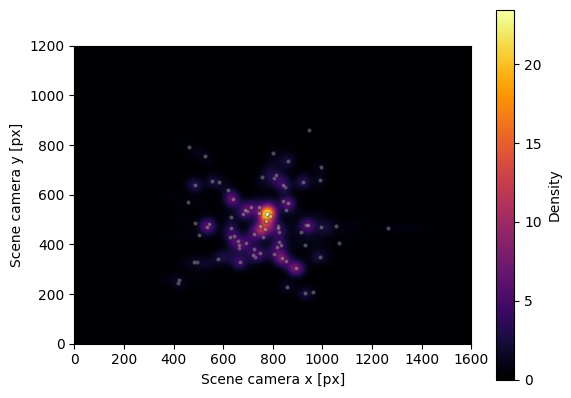

In [14]:
fig, ax = recording.plot_distribution()

We can see a clear centre-bias, as participants tend to look more centrally relative to head position.